# Surfbreak
A toolkit for the physical analysis and modeling of surf breaks from video.

### Key Goals
_or, Why do Users Even Care_
1. Calibrate global surf forecasts to the actual local conditions 
1. Extract from video some of the insights of an experienced local surfer
    1. Understand where waves break, at what tides, during what size swell from which direction
    1. Provide a visual, spatial "surf spot guide" with more information presented more clearly
    1. Quantify the best places to catch empty waves _(not just the most popular main peak!)_
1. Provide a foundation for superior surfer tracking and performance analytics
    1. Automatically extract a calibrated coordinate system aligned to the ocean surface
    1. Accurately measure not just waves surfed, but missed opportunities and optimal takeoff locations


### Usage Examples of User-Facing Functionality
_Define the key use cases that deliver value, so a test suite can be built around them_
1. Download and save a surf forecast and surfcam video
1. Detect the primary surfzone and extract aliged, cropped sections of the video
1. Generate sequences of normalized waveform training data from a video `{wavefront_signal, image_coordinates, image}`
    1. From a simple hand-designed wavefront detector
    1. From a CNN model checkpoint pre-trained to detect wavefronts
1. Train a model of the surfzone waveform subject to the constraints of physics
    1. Train a CNN to detect wavefronts using a pre-trained waveform model
1. Calibrate a coordinate transform from image coordinates to a euclidean plane aligned to the ocean surface
1. Detect plunging waves and shoulders suitable for surfing
1. Generate a visual summary of a surfzone from a single video

# Tests

## Download and save a surf forecast and surfcam video

In [ ]:
# Our known good surf spots are stored in load_videos.py, along with their surfline spot ID
from surfbreak.load_videos import SURF_SPOTS, save_forecast_and_stream, decode_frame_sequence
SURF_SPOTS

{'shirahama': {'cam_url': 'https://www.youtube.com/watch?v=xuP8xIbZvmo',
  'spotid': '584204204e65fad6a77098c4'},
 'shinmaiko': {'cam_url': 'https://www.youtube.com/watch?v=3dkBkAjNay4',
  'spotid': '584204204e65fad6a77097f3'}}

[cli][info] Found matching plugin youtube for URL https://www.youtube.com/watch?v=3dkBkAjNay4
[cli][info] Available streams: 144p (worst), 240p, 360p, 480p, 720p (best)
[cli][info] Opening stream: 720p (hls)
[stream.hls][info] Stopping stream early after 10
[cli][info] Stream ended
[cli][info] Closing currently open stream...

Decoding ./tmp/shinmaiko_1594383518_SURF-25cm.ts  Duration: 0.2m (10.00s)  FPS: 30.0  Emitting 1/4 of frames 


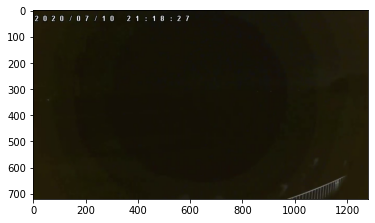

In [ ]:
import os
from matplotlib import pyplot as plt

results = save_forecast_and_stream(surf_spot='shinmaiko', folder='./tmp/', duration_s=10, capture_output=True)
sd = results['surf_data']
assert len(sd['data']['wave']) > 4
assert sd['data']['wave'][1]['surf']['max'] >= 0

print(results['video_subprocess'].stdout.decode())
assert results['video_subprocess'].returncode == 0
video_filesize_bytes = os.path.getsize(results['video_filepath'])
assert video_filesize_bytes > 2e5 #(Even a ~10s video Should be larger than 200kb)

frames = decode_frame_sequence(results['video_filepath'], duration_s=2, start_s=1, RGB=True)
plt.imshow(frames[0])
assert(frames[0].mean(axis=2).std() > 0.01) # Make sure it's not just blank or uniform data

os.remove(results['video_filepath'])
os.remove(results['video_filepath'][:-3] + '.json')

## Detect the primary surfzone and extract aliged, cropped sections of the video
Surfbreak uses [Graphchain](https://github.com/radix-ai/graphchain) to cache [Dask computation graphs](https://dask.org/), providing intelligent automatic caching of intermediate results. 

This enables the definition of complete ML training pipelines that can run efficiently without the explicit definition of intermediate datasets or model artifacts. A visualization of one simple dask graph can be seen below.

Decoding ../tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/4 of frames 
(1080, 1920, 3)


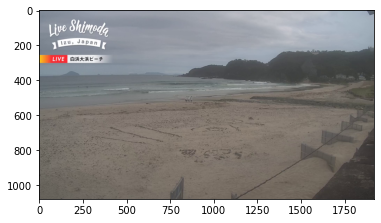

In [ ]:
test_video_filepath = '../tmp/shirahama_1590387334_SURF-93cm.ts'
frames = decode_frame_sequence(test_video_filepath, duration_s=2, start_s=0, RGB=True)
plt.imshow(frames[0])
print(frames[0].shape)

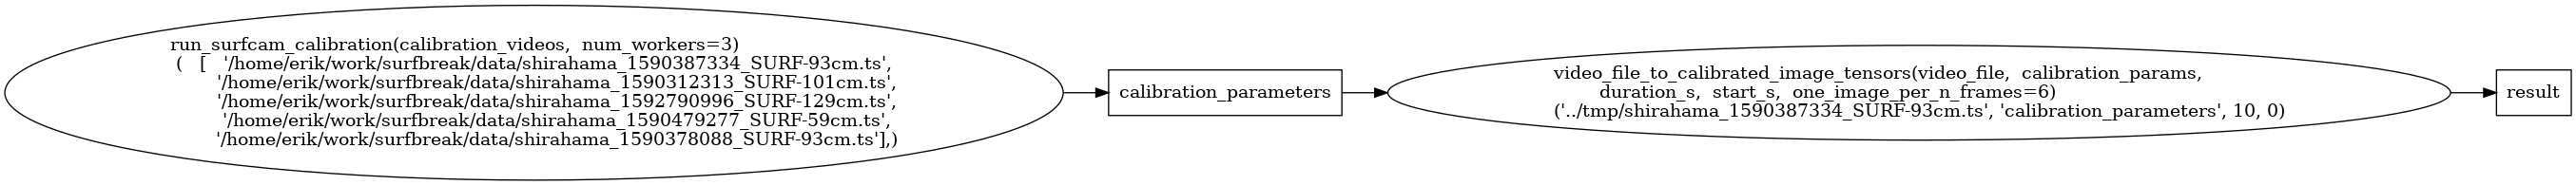

In [ ]:
import matplotlib.pyplot as plt
from surfbreak import graphutils
from surfbreak import pipelines
import graphchain

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
img_tensor_graph = pipelines.video_to_calibrated_image_tensor(test_video_filepath,
                                                              duration_s=10, start_s=0)
graphutils.visualize(img_tensor_graph)

(145, 1490, 100)


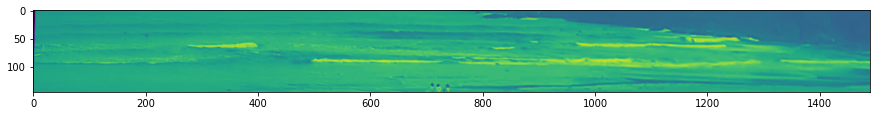

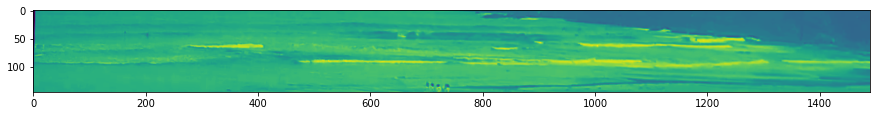

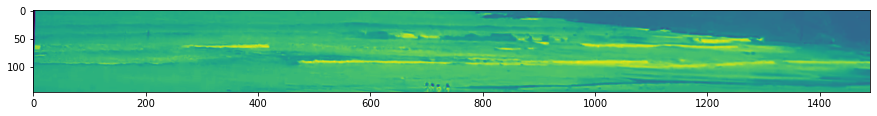

In [ ]:
img_tensor = graphchain.get(img_tensor_graph, 'result')
print(img_tensor.shape)
for frame_idx in range(3):
    plt.figure(figsize=(15,5))
    plt.imshow(img_tensor[:,:,frame_idx*4])
    plt.show()

## Generate sequences of normalized waveform training data from a video
Waveform training data consists of `{wavefront_signal, image_coordinates, image}`
1. From a simple hand-designed wavefront detector
1. From a CNN model checkpoint pre-trained to detect wavefronts